In [50]:

#coding:utf-8 
%matplotlib inline
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy


from graphviz import Source, Graph

def plot_tree(g, mapper = None):
    if mapper is None:
        return g
    src = g.source
    for k, v in mapper.items():
        src  = src.replace(k+'<', v+'<')
    return Source(src)
def plot_importance_g(bst, mapper, **argv):
    ax=xgb.plot_importance({mapper[k]:v for k,v in bst.get_score(importance_type='gain').items()}, **argv )
    fig = ax.figure
    fig.set_size_inches(32, 32)

    
def plot_importance(bst, mapper, **argv):
    ax=xgb.plot_importance({mapper[k]:v for k,v in bst.get_fscore().items()}, **argv )
    fig = ax.figure
    fig.set_size_inches(32, 32)
    
    
def model_dump(bst, mapper, fout, **argv):
    bst.dump_model('tmp.txt')
    src = open('tmp.txt').read()
    for k, v in mapper.items():
        src  = src.replace(k+'<', v+'<')
    f = open(fout, 'w')
    f.write(src.encode('utf-8'))
    f.close()
import re
def parse_kvfile(f, dtype=int, ktype=str):
    dic = [(ktype(re.split(r'\s+', line)[0]), dtype(re.split(r'\s+', line)[1])) for  line in open(f) if line.strip()!='']
    return dict(dic)

from math import sqrt
def multipl(a,b):
    sumofab=0.0
    for i in range(len(a)):
        temp=a[i]*b[i]
        sumofab+=temp
    return sumofab

def corrcoef(x,y):
    n=len(x)
    sum1=sum(x)
    sum2=sum(y)
    sumofxy=multipl(x,y)
    sumofx2 = sum([pow(i,2) for i in x])
    sumofy2 = sum([pow(j,2) for j in y])
    num=sumofxy-(float(sum1)*float(sum2)/n)
    den=sqrt((sumofx2-float(sum1**2)/n)*(sumofy2-float(sum2**2)/n))
    return num/den

In [43]:
file_path='/Users/zhuribing/Documents/audio-test/'
data=pd.read_csv(file_path+'featdata.txt', sep=' ');
data.columns

Index(['label', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'S', 'Sn',
       'SegmentDurationScores', 'LogSegProb', 'IwLogSegProb', 'Spectral1',
       'PercentPhoneMatch', 'LikelihoodOfSpectralVectorO',
       'PosteriorProbabilityPhoneme', 'GOP', 'Amscore', 'PercentX-V',
       'PercentX-C', 'StddevX-V', 'StddevX-C', 'VarcoX-V', 'VarcoX-C',
       'RpviX-V', 'RpviX-C', 'NpviX-V', 'NpviX-C', 'Numwds', 'Globsegdur',
       'Segdur', 'Uttsegdur', 'Wdpchk', 'Secpchk', 'Wpsec', 'Wpsecutt',
       'Secpchkmeandev', 'Wdpchkmeandev', 'SilBasicFeats-SilNum',
       'SilBasicFeats-Silpwd', 'SilBasicFeats-Silpsec',
       'SilBasicFeats-Silmean', 'SilBasicFeats-Silmeandev',
       'SilBasicFeats-Silstddev', 'LongSilBasicFeats-Longpfreq',
       'LongSilBasicFeats-Longpmn', 'LongSilBasicFeats-Longpwd',
       'LongSilBasicFeats-Longpmeandev', 'LongSilBasicFeats-Longpstddev',
       'DisfluFeats-Numdff', 'DisfluFeats-Dpsec', 'Repfreq', 'Tpsec',
       'Tpsecutt'],
      dtype='object')

In [42]:
data[['GOP','PercentPhoneMatch', 'Spectral1', 'LikelihoodOfSpectralVectorO',
   'PosteriorProbabilityPhoneme', 'Secpchkmeandev', 'Secpchk']].describe()

,GOP,PercentPhoneMatch,Spectral1,LikelihoodOfSpectralVectorO,PosteriorProbabilityPhoneme,Secpchkmeandev,Secpchk
count,5467.000000,5467.000000,5467.000000,5467.000000,5467.000000,5467.000000,5467.000000
mean,-0.469675,0.438949,2.532195,74.979024,-9.522592,0.416694,1.155499
std,0.553878,0.217815,0.801936,63.325569,41.894201,0.356556,0.650621
min,-4.319830,0.000000,0.110264,-357.757000,-1173.920000,0.000000,0.070000
25%,-0.657839,0.282051,1.952900,57.052150,-10.845800,0.165000,0.730000
50%,-0.316461,0.424242,2.499770,70.585500,-5.121150,0.357143,0.973333
75%,-0.104758,0.588235,3.067440,84.635850,-1.710990,0.584444,1.380000
max,2.006870,1.600000,5.804000,1788.080000,992.963000,2.650000,6.220000


In [45]:
data.describe()

,label,L1,L2,L3,L4,L5,L6,L7,S,Sn,...,LongSilBasicFeats-Longpfreq,LongSilBasicFeats-Longpmn,LongSilBasicFeats-Longpwd,LongSilBasicFeats-Longpmeandev,LongSilBasicFeats-Longpstddev,DisfluFeats-Numdff,DisfluFeats-Dpsec,Repfreq,Tpsec,Tpsecutt
count,5467.000000,5467.000000,5467.000000,5467.000000,5467.000000,5467.000000,5467.000000,5467.000000,5467.000000,5467.000000,...,5467.000000,5467.000000,5467.000000,5467.000000,5467.000000,5467.000000,5467.000000,5467.000000,5467.000000,5467.000000
mean,3.370770,-805.050709,-97.241590,-32.328256,-157.221745,-232.237988,-32.328256,-51.647519,0.144754,0.926404,...,2.580940,0.231936,0.080391,0.114455,0.128668,2.580940,0.599069,0.011279,2.478106,1.602717
std,1.287266,553.680128,40.703619,14.415463,63.391531,66.889895,14.415463,35.606821,0.058589,0.350008,...,2.599816,0.267307,0.112669,0.179841,0.206481,2.599816,0.374421,0.040606,0.681557,0.492598
min,0.000000,-11408.400000,-789.748000,-264.839000,-509.095000,-633.881000,-264.839000,-1241.640000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.523560,0.143956
25%,3.000000,-989.430500,-112.483500,-37.359300,-184.221000,-258.206500,-37.359300,-59.287050,0.105000,0.700469,...,1.000000,0.035000,0.010000,0.000000,0.000000,1.000000,0.366300,0.000000,2.051280,1.271385
50%,4.000000,-677.617000,-89.710500,-29.271900,-146.105000,-221.348000,-29.271900,-44.260900,0.137143,0.920326,...,2.000000,0.170000,0.048000,0.045000,0.047842,2.000000,0.607903,0.000000,2.395210,1.571370
75%,4.000000,-465.749000,-72.082600,-23.523350,-116.455000,-189.903000,-23.523350,-34.643600,0.175000,1.149760,...,3.000000,0.324143,0.105166,0.165000,0.182783,3.000000,0.847458,0.000000,2.803740,1.896220
max,6.000000,-20.344900,-11.711400,-3.513420,-4.762310,-53.007900,-3.513420,-6.890690,0.815000,1.968090,...,33.000000,3.310000,1.365000,2.335000,2.832490,33.000000,2.173910,0.600000,14.285700,4.709240


In [72]:
file_path='/Users/zhuribing/Documents/audio-test/'
# df_train=pd.read_csv(file_path+'train.dat', sep=' ');
# df_test = pd.read_csv(file_path+'master.test', sep=' ');
df_test = pd.read_csv(file_path+'test.dat', sep=' ');
# df_val = pd.read_csv(file_path+'eval.dat', sep=' ');

df_train=pd.read_csv(file_path+'pron_exact_rank_diff.train', sep=' ');
#df_test = pd.read_csv(file_path+'pron_exact_rank.test', sep=' ');
df_val = pd.read_csv(file_path+'pron_exact_rank.val', sep=' ');


mask = ((df_train.PosteriorProbabilityPhoneme.values > -1172) | (df_train.L1.values > -11000.0) | (df_train.GOP.values  > -4) & (df_train.GOP.values < 2))
df_train = df_train.loc[mask]

mask = ((df_val.PosteriorProbabilityPhoneme.values > -1172) | (df_val.L1.values > -11000.0) | (df_val.GOP.values  > -4) & (df_val.GOP.values < 2))
df_val = df_val[mask];
cols = df_train.columns.tolist()

#去除几个特征，做多个结果，再融合；类似RF的特征扰动
# to_drop = ['label', 'L1', 'L4', 'L7', 'S', 'Sn',
#        'SegmentDurationScores', 'LogSegProb','Amscore', 'PercentX-V',
#        'PercentX-C', 'StddevX-V', 'StddevX-C', 'VarcoX-V', 'VarcoX-C',
#        'SilBasicFeats-Silmean', 'SilBasicFeats-Silmeandev',
#        'SilBasicFeats-Silstddev', 'LongSilBasicFeats-Longpfreq',
#        'LongSilBasicFeats-Longpmn', 'LongSilBasicFeats-Longpwd',
#        'LongSilBasicFeats-Longpmeandev', 'LongSilBasicFeats-Longpstddev',
#        'DisfluFeats-Numdff', 'DisfluFeats-Dpsec', 'Repfreq',
#        'Tpsecutt']

to_drop = ['GOP','label']
features = list(np.setdiff1d(cols, to_drop))
print(features)

x_train = df_train[features]
y_train = df_train['label']

x_val = df_val[features]
y_val = df_val['label']

x_test = df_test[features]
y_test = df_test['label']

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

dtrain = xgb.DMatrix(x_train.values, y_train)
dtest = xgb.DMatrix(x_test.values)
dval = xgb.DMatrix(x_val.values, y_val)
print ('done.')

print('training model...')
# watchlist = [(dtrain, 'train')]
watchlist = [(dval,'eval'),(dtrain, 'train')]
#param['objective'] = 'multi:softmax'
param = {
        'booster': 'gbtree',
        'objective': 'multi:softmax',
        'num_class':7,
#         'objective': 'reg:linear',
#         'eval_metric': 'mae',
        'eta': 0.1,  #0.1  0.25
        'num_round': 60,  #1500
        'colsample_bytree': 0.65,
        'subsample': 0.9,
        'max_depth': 5,
        'min_child_weight':5,
        'nthread': 8,  #-1 8
#         'seed': 20190827,
        'silent': 1,
    }


bst0 = xgb.train(param, dtrain, param['num_round'], watchlist, verbose_eval=5)
# bst = xgb.train(param, dtrain, param['num_round'], watchlist, verbose_eval=20, early_stopping_rounds=100)

print('generating prediction...')
pred = bst0.predict(dtest)  
predmodel = pred;
print ('dtest, acc =%f' % (1 - (sum( int(pred[i]) != y_test[i] for i in range(len(y_test))) / float(len(y_test)) )))

print ('dtest, acc(+1/-1)=%f' % (1 - (sum( (int(pred[i]) != y_test[i] and int(pred[i])+1 != y_test[i] and int(pred[i])-1 != y_test[i]) for i in range(len(y_test))) / float(len(y_test)))))


['Amscore', 'DisfluFeats-Dpsec', 'DisfluFeats-Numdff', 'Globsegdur', 'IwLogSegProb', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'LikelihoodOfSpectralVectorO', 'LogSegProb', 'LongSilBasicFeats-Longpfreq', 'LongSilBasicFeats-Longpmeandev', 'LongSilBasicFeats-Longpmn', 'LongSilBasicFeats-Longpstddev', 'LongSilBasicFeats-Longpwd', 'NpviX-C', 'NpviX-V', 'Numwds', 'PercentPhoneMatch', 'PercentX-C', 'PercentX-V', 'PosteriorProbabilityPhoneme', 'Repfreq', 'RpviX-C', 'RpviX-V', 'S', 'Secpchk', 'Secpchkmeandev', 'Segdur', 'SegmentDurationScores', 'SilBasicFeats-SilNum', 'SilBasicFeats-Silmean', 'SilBasicFeats-Silmeandev', 'SilBasicFeats-Silpsec', 'SilBasicFeats-Silpwd', 'SilBasicFeats-Silstddev', 'Sn', 'Spectral1', 'StddevX-C', 'StddevX-V', 'Tpsec', 'Tpsecutt', 'Uttsegdur', 'VarcoX-C', 'VarcoX-V', 'Wdpchk', 'Wdpchkmeandev', 'Wpsec', 'Wpsecutt']
(9469, 53)
(252, 53)
(50, 53)
done.
training model...
[0]	eval-merror:0.559524	train-merror:0.535748
[5]	eval-merror:0.543651	train-merror:0.487908
[10]	e

In [71]:
file_path='/Users/zhuribing/Documents/audio-test/'
# df_train=pd.read_csv(file_path+'train.dat', sep=' ');
# df_test = pd.read_csv(file_path+'master.test', sep=' ');
df_test = pd.read_csv(file_path+'test.dat', sep=' ');
# df_val = pd.read_csv(file_path+'eval.dat', sep=' ');


df_train=pd.read_csv(file_path+'pron_exact_rank_diff.train', sep=' ');
# df_test = pd.read_csv(file_path+'pron_exact_rank.test', sep=' ');
df_val = pd.read_csv(file_path+'pron_exact_rank.val', sep=' ');


mask = ((df_train.PosteriorProbabilityPhoneme.values > -1172) | (df_train.L1.values > -11000.0) | (df_train.GOP.values  > -4) & (df_train.GOP.values < 2))
df_train = df_train.loc[mask]

mask = ((df_val.PosteriorProbabilityPhoneme.values > -1172) | (df_val.L1.values > -11000.0) | (df_val.GOP.values  > -4) & (df_val.GOP.values < 2))
df_val = df_val[mask];
cols = df_train.columns.tolist()

#去除几个特征，做多个结果，再融合；类似RF的特征扰动
# to_drop = ['L7','label', 'Amscore', 'DisfluFeats-Dpsec', 'DisfluFeats-Numdff', 'Globsegdur', 'IwLogSegProb', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'LikelihoodOfSpectralVectorO', 'LogSegProb', 'LongSilBasicFeats-Longpfreq', 'LongSilBasicFeats-Longpmeandev', 'LongSilBasicFeats-Longpmn', 'LongSilBasicFeats-Longpstddev', 'LongSilBasicFeats-Longpwd', 'NpviX-C', 'NpviX-V', 'Numwds', 'PercentPhoneMatch', 'PercentX-C', 'PercentX-V', 'PosteriorProbabilityPhoneme', 'Repfreq', 'RpviX-C', 'RpviX-V', 'S', 'Secpchk', 'Secpchkmeandev', 'Segdur', 'SegmentDurationScores', 'SilBasicFeats-SilNum', 'SilBasicFeats-Silmean', 'SilBasicFeats-Silmeandev', 'SilBasicFeats-Silpsec', 'SilBasicFeats-Silpwd', 'SilBasicFeats-Silstddev', 'Sn', 'Spectral1', 'StddevX-C', 'StddevX-V', 'Tpsec', 'Tpsecutt', 'Uttsegdur', 'VarcoX-C', 'VarcoX-V', 'Wdpchk', 'Wdpchkmeandev', 'Wpsec', 'Wpsecutt']
to_drop = ['label','PercentX-C']
features = list(np.setdiff1d(cols, to_drop))
print(features)

x_train = df_train[features]
y_train = df_train['label']

x_val = df_val[features]
y_val = df_val['label']

x_test = df_test[features]
y_test = df_test['label']

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

dtrain = xgb.DMatrix(x_train.values, y_train)
dtest = xgb.DMatrix(x_test.values)
dval = xgb.DMatrix(x_val.values, y_val)
print ('done.')

print('training model...')
# watchlist = [(dtrain, 'train')]
watchlist = [(dval,'eval'),(dtrain, 'train')]
#param['objective'] = 'multi:softmax'
param = {
        'booster': 'gbtree',
        'objective': 'multi:softmax',
        'num_class':7,
#         'objective': 'reg:linear',
#         'eval_metric': 'mae',
        'eta': 0.1,  #0.1  0.25
        'num_round': 50,  #1500
        'colsample_bytree': 0.65,
        'subsample': 0.9,
        'max_depth': 5,
        'min_child_weight':5,
        'nthread': 8,  #-1 8
#         'seed': 20190827,
        'silent': 1,
    }


bst1 = xgb.train(param, dtrain, param['num_round'], watchlist, verbose_eval=5)
# bst = xgb.train(param, dtrain, param['num_round'], watchlist, verbose_eval=20, early_stopping_rounds=100)

#bst1.save_model(file_path+'/xgb.bin1');
print('generating prediction...')
pred = bst1.predict(dtest)  
predmodel1 = pred;

print ('dtest, acc =%f' % (1 - (sum( int(pred[i]) != y_test[i] for i in range(len(y_test))) / float(len(y_test)) )))

print ('dtest, acc(+1/-1) =%f' % ( 1 - (sum( (int(pred[i]) != y_test[i] and int(pred[i])+1 != y_test[i] and int(pred[i])-1 != y_test[i]) for i in range(len(y_test))) / float(len(y_test))) ))



['Amscore', 'DisfluFeats-Dpsec', 'DisfluFeats-Numdff', 'GOP', 'Globsegdur', 'IwLogSegProb', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'LikelihoodOfSpectralVectorO', 'LogSegProb', 'LongSilBasicFeats-Longpfreq', 'LongSilBasicFeats-Longpmeandev', 'LongSilBasicFeats-Longpmn', 'LongSilBasicFeats-Longpstddev', 'LongSilBasicFeats-Longpwd', 'NpviX-C', 'NpviX-V', 'Numwds', 'PercentPhoneMatch', 'PercentX-V', 'PosteriorProbabilityPhoneme', 'Repfreq', 'RpviX-C', 'RpviX-V', 'S', 'Secpchk', 'Secpchkmeandev', 'Segdur', 'SegmentDurationScores', 'SilBasicFeats-SilNum', 'SilBasicFeats-Silmean', 'SilBasicFeats-Silmeandev', 'SilBasicFeats-Silpsec', 'SilBasicFeats-Silpwd', 'SilBasicFeats-Silstddev', 'Sn', 'Spectral1', 'StddevX-C', 'StddevX-V', 'Tpsec', 'Tpsecutt', 'Uttsegdur', 'VarcoX-C', 'VarcoX-V', 'Wdpchk', 'Wdpchkmeandev', 'Wpsec', 'Wpsecutt']
(9469, 53)
(252, 53)
(50, 53)
done.
training model...
[0]	eval-merror:0.583333	train-merror:0.522019
[5]	eval-merror:0.535714	train-merror:0.479142
[10]	eval-mer

In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


ret = [int((predmodel[i]*0.8) + (predmodel1[i]*0.2)) for i in range(len(y_test))]
print ('dtest, acc =%f' % (1 - (sum( int(ret[i]) != y_test[i] for i in range(len(y_test))) / float(len(y_test)) )))
print ('dtest, acc(+1/-1) =%f' % (1- (sum( (int(ret[i]) != y_test[i] and int(ret[i])+1 != y_test[i] and int(ret[i])-1 != y_test[i]) for i in range(len(y_test))) / float(len(y_test)) )))

print(confusion_matrix(y_test, ret))
print(classification_report(y_test, ret))

print('predicting,  Corr=%f' % (corrcoef(ret,y_test)))

# print(ret)
# print(predmodel)
# print(predmodel1)

dtest, acc =0.220000
dtest, acc(+1/-1) =0.760000
[[1 0 0 1 1 0]
 [1 1 4 4 0 0]
 [0 0 2 8 6 0]
 [0 0 1 5 8 0]
 [0 0 0 2 2 0]
 [0 0 0 0 3 0]]
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       1.00      0.10      0.18        10
           2       0.29      0.12      0.17        16
           3       0.25      0.36      0.29        14
           4       0.10      0.50      0.17         4
           5       0.00      0.00      0.00         3

    accuracy                           0.22        50
   macro avg       0.36      0.24      0.20        50
weighted avg       0.40      0.22      0.21        50

predicting,  Corr=0.524037


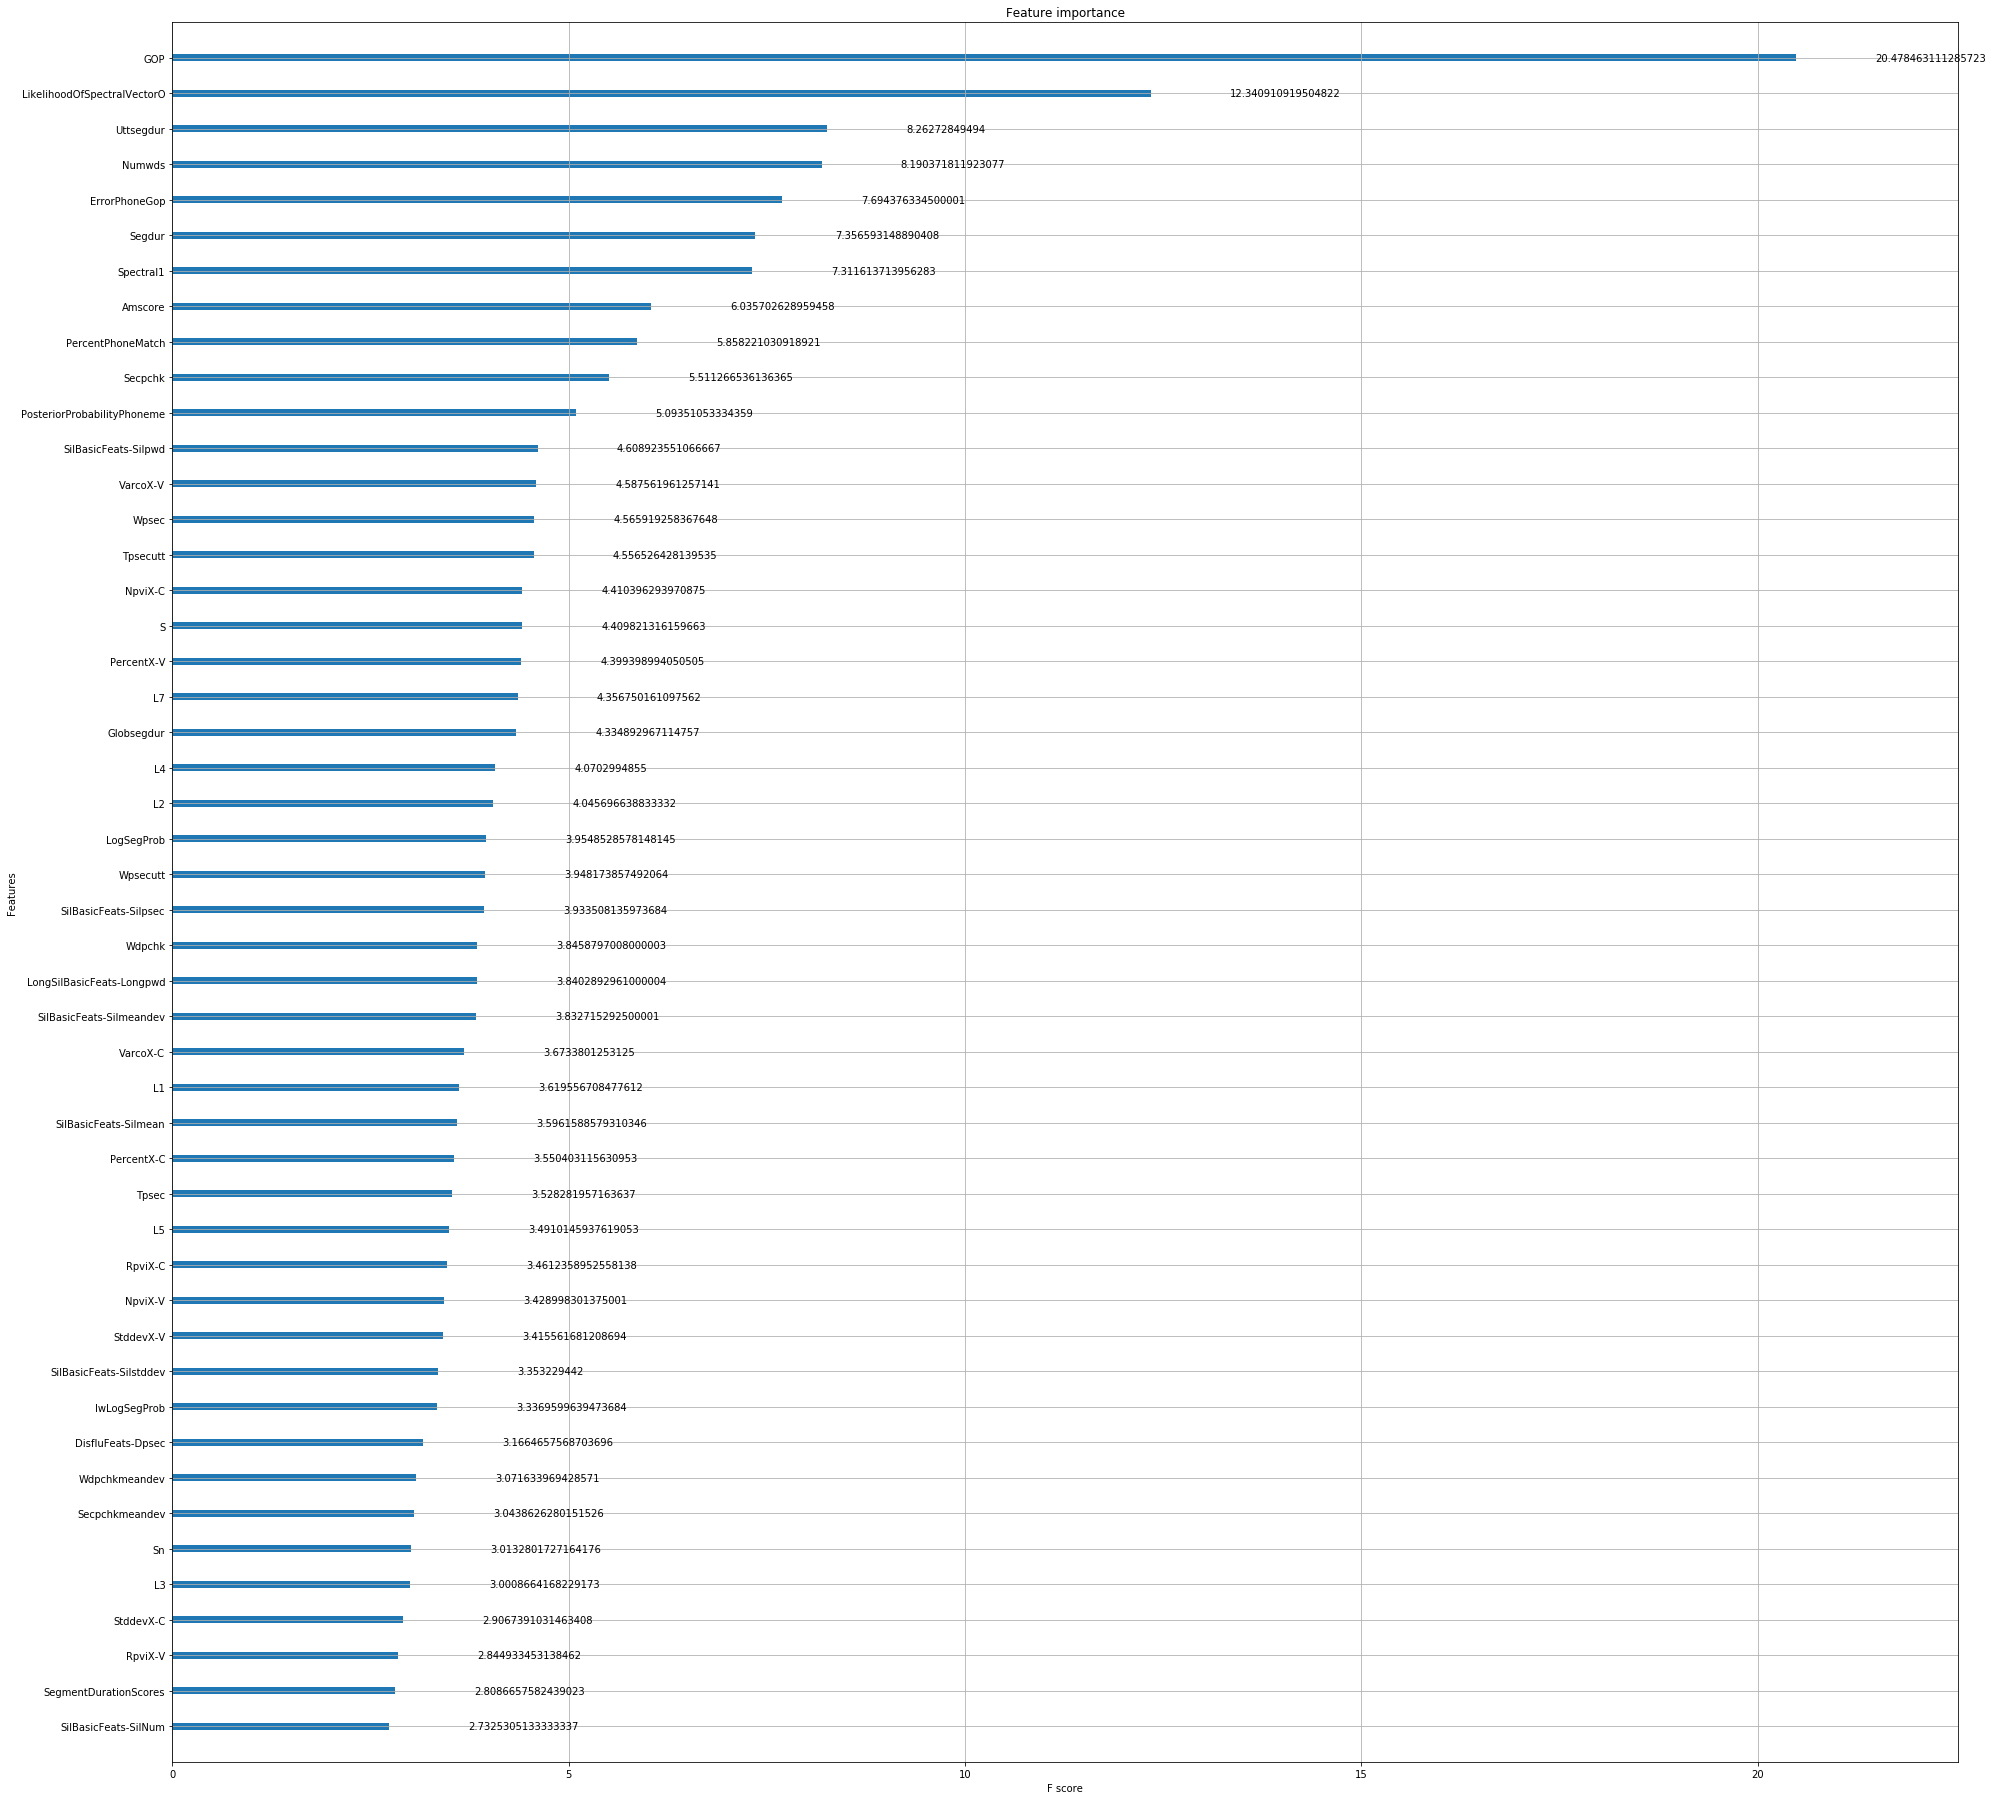

In [80]:
%matplotlib inline
# binary_model_path = '/Users/zhuribing/projects/rt_movie_prefer/movie.xgb'
# idx_file_path = '/Users/zhuribing/projects/rt_movie_prefer/idx.txt'
# binary_model_path = '/Users/zhuribing/Documents/audio-test/xgb_pron.model'
binary_model_path = '/Users/zhuribing/Documents/audio-test/xgb_pron.amw_0.5.model'
# binary_model_path = '/Users/zhuribing/Documents/audio-test/xgb_model.libsvm'
idx_file_path = '/Users/zhuribing/Documents/audio-test/audio_featmap.txt'


bst = xgb.Booster()
bst.load_model(binary_model_path) #二进制文件 model_1_2_v2_1017 model_1_2_v2_925  model_11_7
mapper = {'f'+ str(k) : v  for k,v in parse_kvfile(idx_file_path, dtype=str).items()}
# [(k,v) for k,v in mapper.items() if re.match(r'mt_other_applist_v2_com\.letv\.android\.compass.*', v)]
# 
# one_tree = xgb.to_graphviz(bst, num_trees=1)
# # one_tree.view()
# one_tree_map = plot_tree(one_tree, mapper)
# one_tree_map.view()

plot_importance_g(bst, mapper)

# plot_importance(bst, mapper)


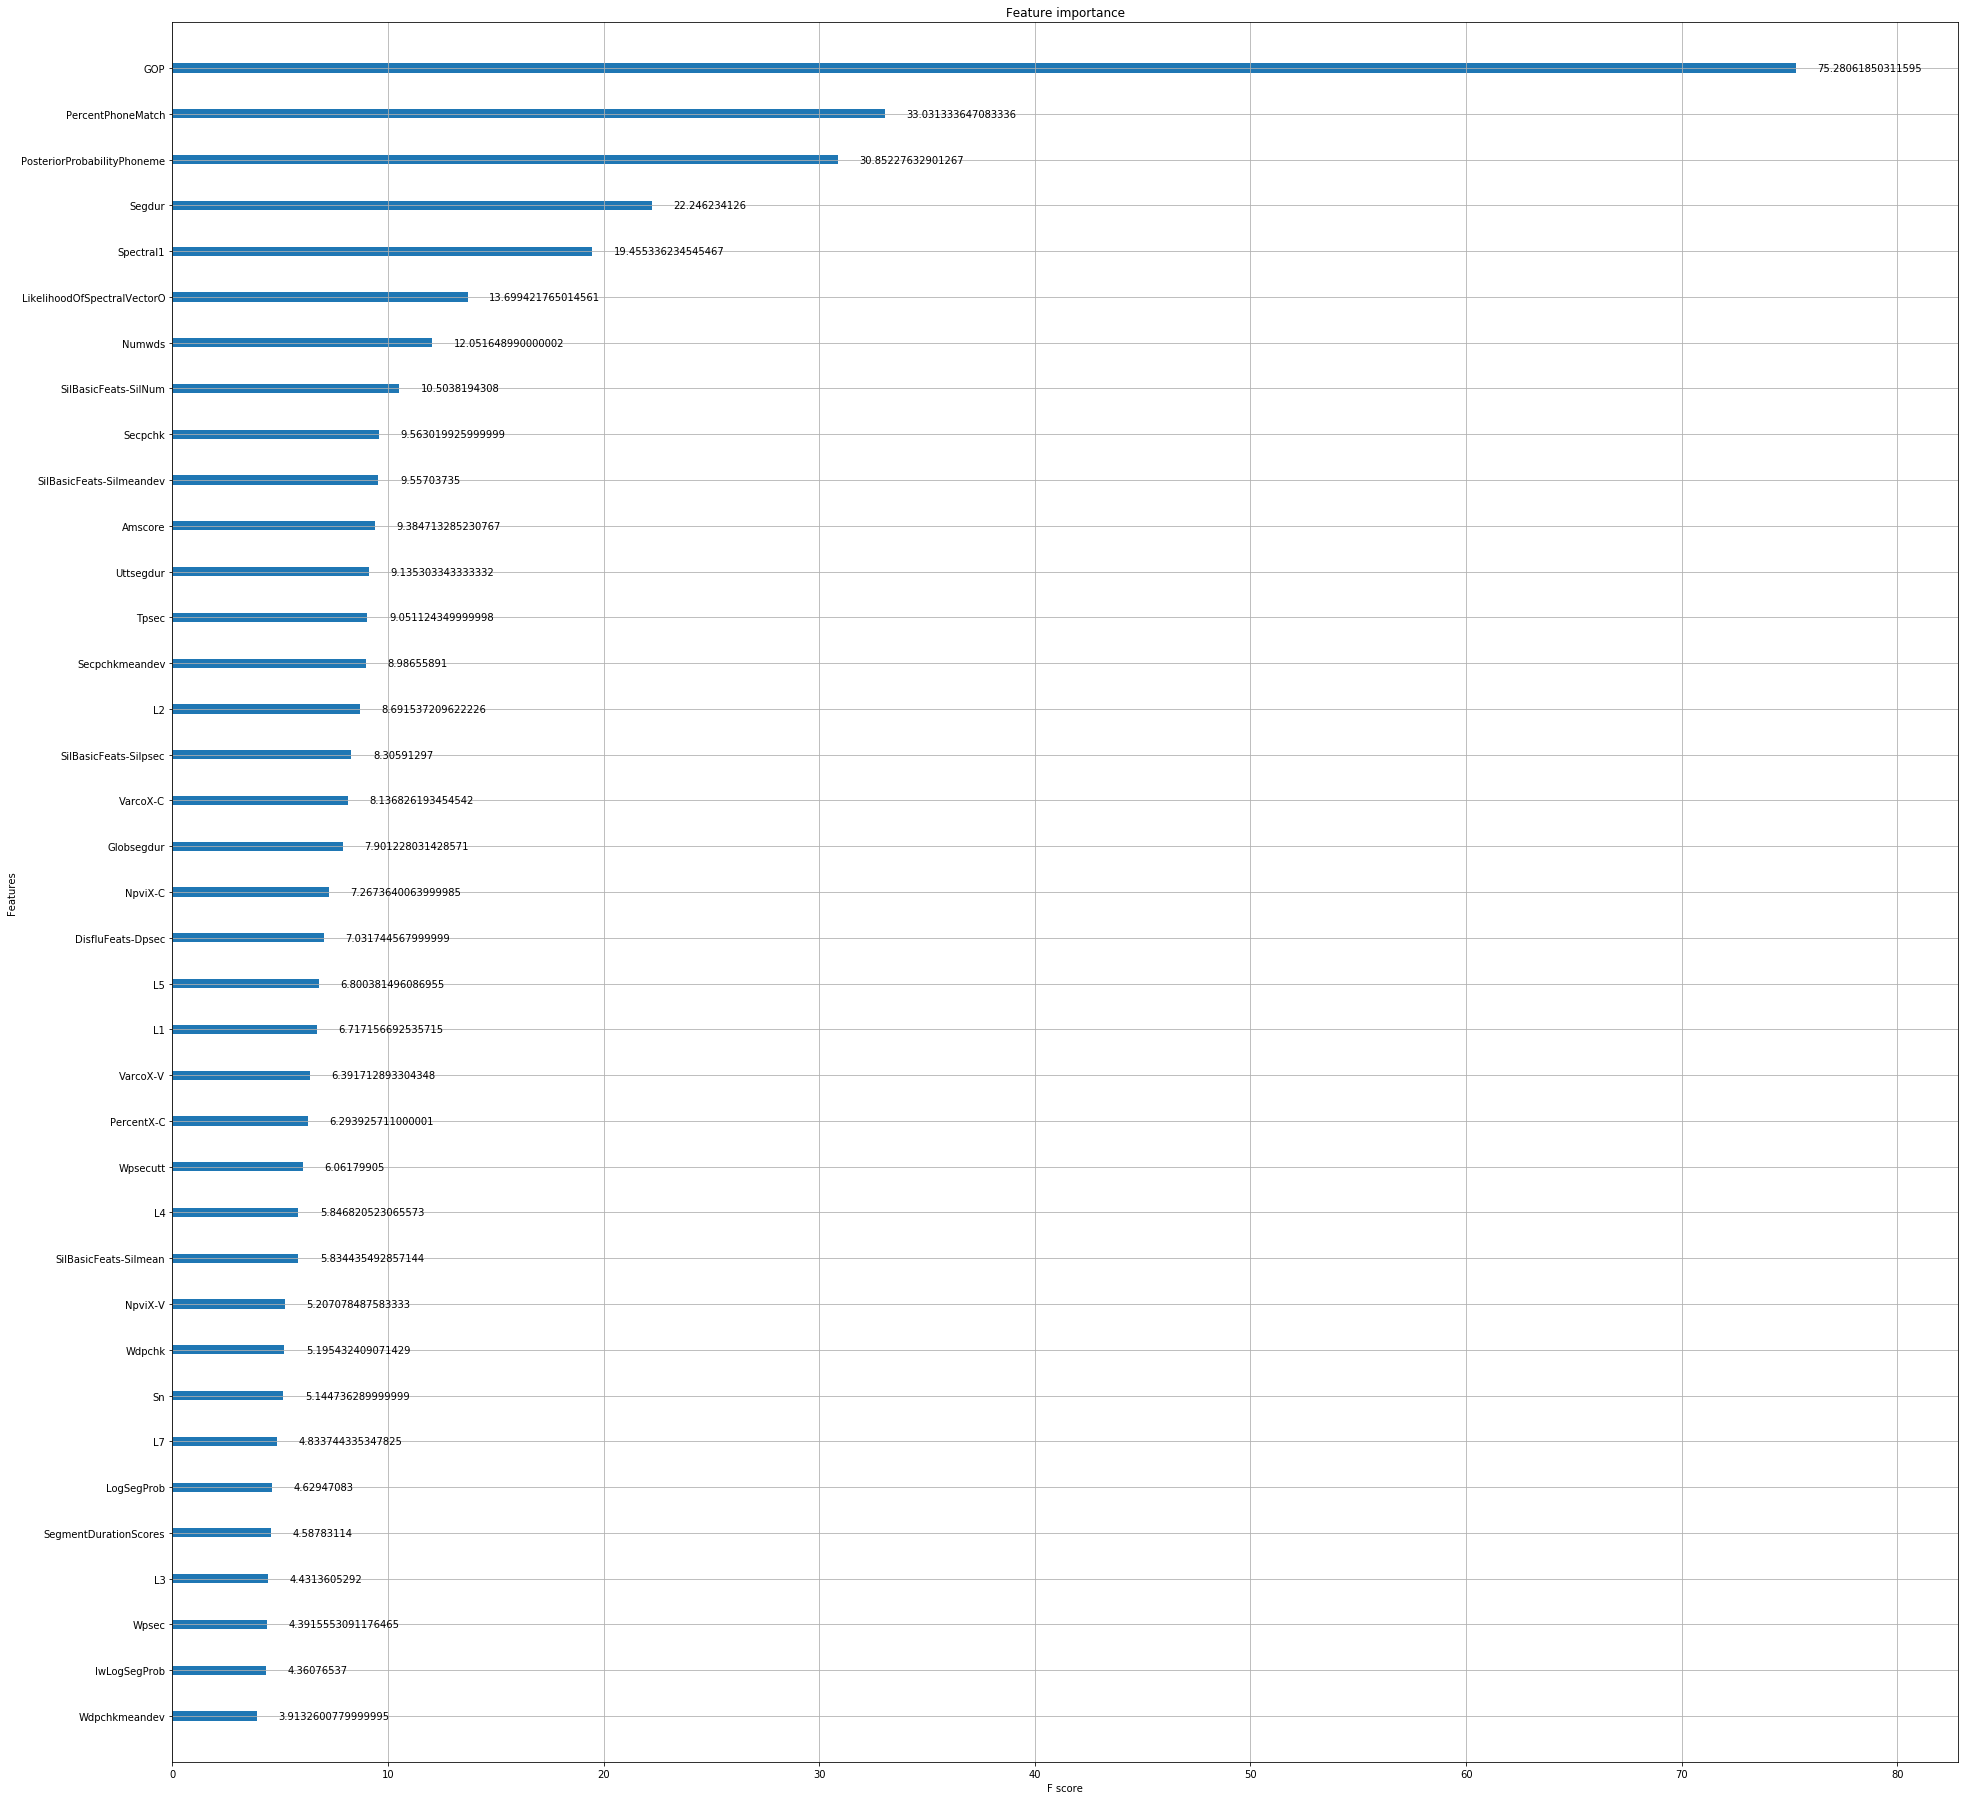

In [22]:
plot_importance_g(bst, mapper)

In [ ]:
1 13 0.590164 PercentPhoneMatch
1 16 0.513423 GOP
1 12 0.470760 Spectral1
1 14 0.396175 LikelihoodOfSpectralVectorO
1 15 0.382590 PosteriorProbabilityPhoneme
1 36 0.361773 Secpchkmeandev
1 33 0.311994 Secpchk
1 2 -0.310450 L3
1 5 -0.310451 L6
1 4 -0.338485 L5
1 1 -0.374180 L2
1 11 -0.377405 IwLogSegProb

In [39]:
%matplotlib inline
one_tree = xgb.to_graphviz(bst, num_trees=1)
# one_tree.view()
one_tree_map = plot_tree(one_tree, mapper)
one_tree_map.view()

'Source.gv.pdf'

In [38]:
two_tree = xgb.to_graphviz(bst, num_trees=2)
# one_tree.view()
two_tree_map = plot_tree(two_tree, mapper)
two_tree_map.view()

'Source.gv.pdf'